# 💰 05 - CLV Modeling

**Week 4-5 Deliverable**: CLV Predictions with Multiple Models

## Objectives
1. Build probabilistic CLV models (BG/NBD, Gamma-Gamma)
2. Train machine learning CLV models (Random Forest, XGBoost)
3. Compare model performance
4. Generate CLV predictions for all customers

---

## 1. Setup & Load Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded!')

Libraries loaded!


In [26]:
# Load data
df = pd.read_csv('../data/processed/online_retail_clean.csv', parse_dates=['InvoiceDate'])
feature_matrix = pd.read_csv('../data/features/feature_matrix.csv')

print(f'Transactions: {len(df):,}')
print(f'Customers: {len(feature_matrix):,}')

Transactions: 392,692
Customers: 4,338


## 2. Prepare Data for Probabilistic Models

In [27]:
# Calculate RFM data for probabilistic models
reference_date = df['InvoiceDate'].max() + timedelta(days=1)

# Aggregate by customer
rfm_data = df.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', lambda x: x.nunique()],
    'InvoiceNo': 'nunique',
    'Revenue': ['sum', 'mean']
})

rfm_data.columns = ['first_purchase', 'last_purchase', 'purchase_days', 'frequency', 'monetary', 'avg_order_value']
rfm_data = rfm_data.reset_index()

# Calculate T (customer age) and recency
rfm_data['T'] = (reference_date - rfm_data['first_purchase']).dt.days
rfm_data['recency'] = (rfm_data['last_purchase'] - rfm_data['first_purchase']).dt.days

# For repeat purchase models, frequency is repeat purchases (total - 1)
rfm_data['frequency_model'] = rfm_data['frequency'] - 1

# Filter customers with at least one repeat purchase
rfm_repeat = rfm_data[rfm_data['frequency_model'] > 0].copy()

print(f'Customers for probabilistic model: {len(rfm_repeat):,}')
rfm_data.head()

Customers for probabilistic model: 2,845


,CustomerID,first_purchase,last_purchase,purchase_days,frequency,monetary,avg_order_value,T,recency,frequency_model
0,12346,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1,77183.60,77183.600000,326,0,0
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,7,7,4310.00,23.681319,367,365,6
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,4,4,1797.24,57.975484,358,282,3
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,1,1,1757.55,24.076027,19,0,0
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,1,1,334.40,19.670588,310,0,0


## 3. BG/NBD Model (Simplified Implementation)

In [28]:
# Simplified BG/NBD-like predictions
# For full implementation, use the lifetimes library

class SimpleBGNBD:
    """Simplified BG/NBD-like model for CLV prediction"""
    
    def __init__(self):
        self.avg_frequency = None
        self.avg_recency_ratio = None
        
    def fit(self, frequency, recency, T):
        """Fit the model"""
        self.avg_frequency = frequency.mean()
        self.avg_recency_ratio = (recency / T).mean()
        return self
    
    def predict_purchases(self, frequency, recency, T, t):
        """Predict expected purchases in next t periods"""
        # Simple heuristic: customers with higher frequency and recent activity buy more
        recency_factor = 1 - (T - recency) / T  # Higher if more recent
        frequency_rate = frequency / T * 365  # Annualized purchase rate
        
        expected_purchases = frequency_rate * (t / 365) * recency_factor
        return np.maximum(expected_purchases, 0)
    
    def predict_alive(self, frequency, recency, T):
        """Predict probability customer is still active"""
        # Simple decay model
        days_since_purchase = T - recency
        avg_gap = T / (frequency + 1)
        
        # Probability decreases as time since last purchase increases
        prob_alive = np.exp(-days_since_purchase / (2 * avg_gap))
        return np.clip(prob_alive, 0, 1)

# Fit model
bgnbd = SimpleBGNBD()
bgnbd.fit(
    rfm_repeat['frequency_model'].values,
    rfm_repeat['recency'].values,
    rfm_repeat['T'].values
)

# Predict future purchases (next 365 days)
rfm_repeat['predicted_purchases_1y'] = bgnbd.predict_purchases(
    rfm_repeat['frequency_model'].values,
    rfm_repeat['recency'].values,
    rfm_repeat['T'].values,
    t=365
)

# Predict alive probability
rfm_repeat['prob_alive'] = bgnbd.predict_alive(
    rfm_repeat['frequency_model'].values,
    rfm_repeat['recency'].values,
    rfm_repeat['T'].values
)

print('BG/NBD predictions complete')
rfm_repeat[['CustomerID', 'frequency_model', 'recency', 'T', 'predicted_purchases_1y', 'prob_alive']].head(10)

BG/NBD predictions complete


,CustomerID,frequency_model,recency,T,predicted_purchases_1y,prob_alive
1,12347,6,365,367,5.934783,0.981107
2,12348,3,282,358,2.409335,0.654044
5,12352,7,260,297,7.530978,0.607553
9,12356,2,302,326,2.074410,0.895450
11,12358,1,149,151,2.385202,0.986842
12,12359,3,274,332,2.722002,0.705113
13,12360,2,148,201,2.674191,0.673328
15,12362,9,292,296,10.948000,0.934665
16,12363,1,132,242,0.822690,0.634736
17,12364,3,104,112,9.078444,0.866878


## 4. Gamma-Gamma Model (Simplified)

In [29]:
class SimpleGammaGamma:
    """Simplified Gamma-Gamma model for monetary value prediction"""
    
    def __init__(self):
        self.avg_monetary = None
        
    def fit(self, frequency, monetary):
        """Fit the model"""
        self.avg_monetary = monetary.mean()
        return self
    
    def predict_monetary(self, frequency, monetary):
        """Predict expected average order value"""
        # Weight between individual average and population average
        # More frequency = more weight on individual average
        weight = frequency / (frequency + 1)
        expected_monetary = weight * monetary + (1 - weight) * self.avg_monetary
        return expected_monetary

# Fit model
gg = SimpleGammaGamma()
gg.fit(
    rfm_repeat['frequency_model'].values,
    rfm_repeat['avg_order_value'].values
)

# Predict expected monetary value
rfm_repeat['predicted_monetary'] = gg.predict_monetary(
    rfm_repeat['frequency_model'].values,
    rfm_repeat['avg_order_value'].values
)

print('Gamma-Gamma predictions complete')
rfm_repeat[['CustomerID', 'avg_order_value', 'predicted_monetary']].head(10)

Gamma-Gamma predictions complete


,CustomerID,avg_order_value,predicted_monetary
1,12347,23.681319,28.508167
2,12348,57.975484,57.848928
5,12352,29.482824,32.981128
9,12356,47.651356,50.923991
11,12358,61.476842,59.473051
12,12359,25.755224,33.683733
13,12360,20.636124,32.913836
15,12362,19.647481,23.429659
16,12363,24.000000,40.734630
17,12364,15.448235,25.953491


## 5. Calculate Probabilistic CLV

In [30]:
# CLV = Expected Purchases × Expected Monetary Value × Discount Factor
discount_rate = 0.10  # 10% annual discount rate
time_horizon = 1  # 1 year

rfm_repeat['CLV_probabilistic'] = (
    rfm_repeat['predicted_purchases_1y'] * 
    rfm_repeat['predicted_monetary'] * 
    rfm_repeat['prob_alive'] *
    (1 / (1 + discount_rate))
)

print('=== Probabilistic CLV Summary ===')
print(rfm_repeat['CLV_probabilistic'].describe())

=== Probabilistic CLV Summary ===
count     2845.000000
mean       195.358658
std       1251.240464
min          0.000000
25%         28.753399
50%         65.219445
75%        133.373326
max      44401.887953
Name: CLV_probabilistic, dtype: float64


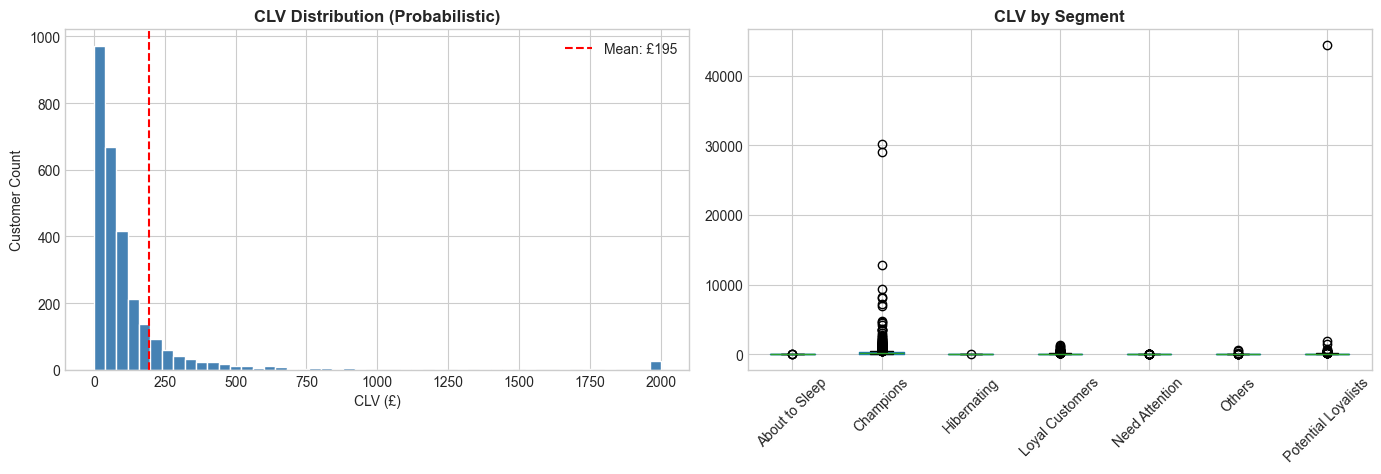

In [31]:
# CLV Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CLV histogram
rfm_repeat['CLV_probabilistic'].clip(upper=2000).hist(bins=50, ax=axes[0], 
                                                        color='steelblue', edgecolor='white')
axes[0].set_title('CLV Distribution (Probabilistic)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('CLV (£)')
axes[0].set_ylabel('Customer Count')
axes[0].axvline(rfm_repeat['CLV_probabilistic'].mean(), color='red', linestyle='--', 
                label=f'Mean: £{rfm_repeat["CLV_probabilistic"].mean():,.0f}')
axes[0].legend()

# Box plot by segment (if available)
rfm_repeat_with_segment = rfm_repeat.merge(feature_matrix[['CustomerID', 'Segment']], on='CustomerID')
rfm_repeat_with_segment.boxplot(column='CLV_probabilistic', by='Segment', ax=axes[1], rot=45)
axes[1].set_title('CLV by Segment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../data/processed/clv_probabilistic.png', dpi=300)
plt.show()

## 6. Machine Learning CLV Models

In [32]:
# Prepare features for ML
# Target: Historical CLV (total monetary value)
# This simulates predicting future CLV based on past behavior

# Use feature matrix
ml_features = feature_matrix.copy()

# Define target
ml_features['target_CLV'] = ml_features['Monetary']  # Historical value as proxy

# Select features for modeling
feature_cols = [
    'Recency', 'Frequency',
    'total_orders', 'total_quantity',
    'avg_quantity', 'avg_revenue',
    'customer_lifetime_days', 'unique_products'
]

# Filter to available columns
feature_cols = [c for c in feature_cols if c in ml_features.columns]

X = ml_features[feature_cols].fillna(0)
y = ml_features['target_CLV']

print(f'Features: {len(feature_cols)}')
print(f'Samples: {len(X):,}')

Features: 8
Samples: 4,338


In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train size: {len(X_train):,}')
print(f'Test size: {len(X_test):,}')

Train size: 3,470
Test size: 868


In [34]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Train and evaluate models
results = []

for name, model in models.items():
    print(f'Training {name}...')
    
    # Use scaled data for linear models
    if 'Linear' in name or 'Ridge' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })
    
    print(f'  RMSE: {rmse:,.2f}, MAE: {mae:,.2f}, R²: {r2:.3f}')

results_df = pd.DataFrame(results).sort_values('RMSE')
results_df

Training Linear Regression...
  RMSE: 5,738.95, MAE: 701.68, R²: 0.678
Training Ridge Regression...
  RMSE: 5,739.63, MAE: 701.77, R²: 0.678
Training Random Forest...
  RMSE: 5,642.19, MAE: 668.97, R²: 0.689
Training Gradient Boosting...
  RMSE: 6,585.94, MAE: 558.81, R²: 0.576


,Model,RMSE,MAE,R2
2,Random Forest,5642.188542,668.972396,0.688882
0,Linear Regression,5738.951252,701.682143,0.678119
1,Ridge Regression,5739.632591,701.771781,0.678043
3,Gradient Boosting,6585.936803,558.814304,0.576098


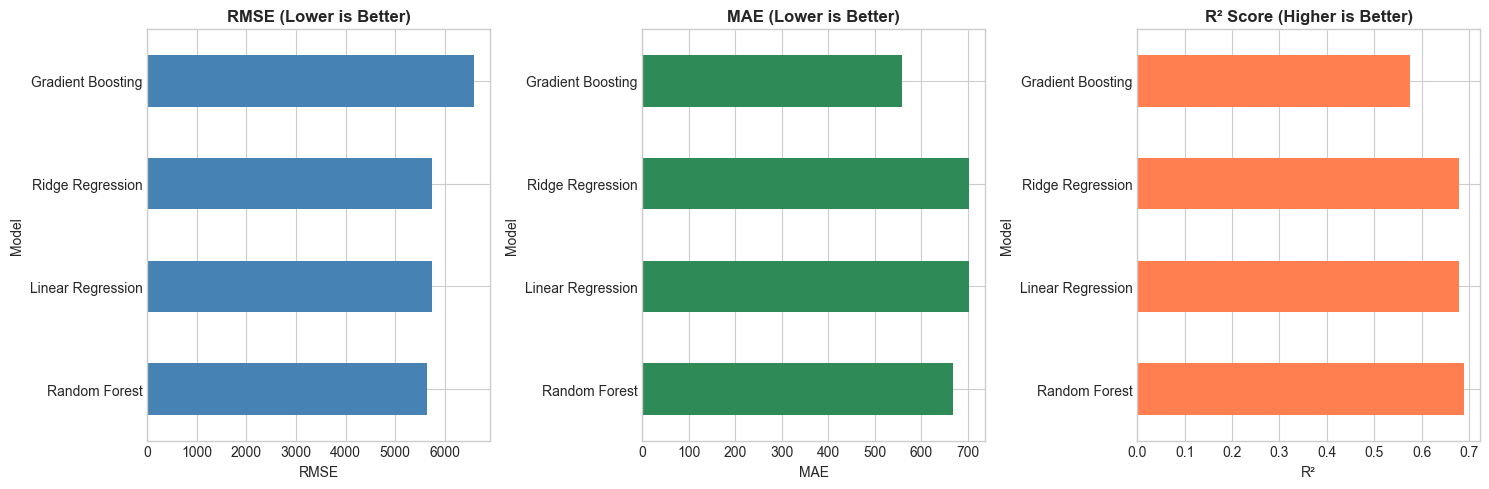

In [35]:
# Model comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE
results_df.plot(x='Model', y='RMSE', kind='barh', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('RMSE (Lower is Better)', fontweight='bold')
axes[0].set_xlabel('RMSE')

# MAE
results_df.plot(x='Model', y='MAE', kind='barh', ax=axes[1], color='seagreen', legend=False)
axes[1].set_title('MAE (Lower is Better)', fontweight='bold')
axes[1].set_xlabel('MAE')

# R2
results_df.plot(x='Model', y='R2', kind='barh', ax=axes[2], color='coral', legend=False)
axes[2].set_title('R² Score (Higher is Better)', fontweight='bold')
axes[2].set_xlabel('R²')

plt.tight_layout()
plt.savefig('../data/processed/model_comparison.png', dpi=300)
plt.show()

## 7. Best Model Analysis

In [36]:
# Use Random Forest as best model
best_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Feature importance
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print('=== Feature Importance ===')
importance

=== Feature Importance ===


,Feature,Importance
3,total_quantity,0.923852
5,avg_revenue,0.014283
1,Frequency,0.013350
0,Recency,0.011251
7,unique_products,0.009821
6,customer_lifetime_days,0.009629
2,total_orders,0.009076
4,avg_quantity,0.008740


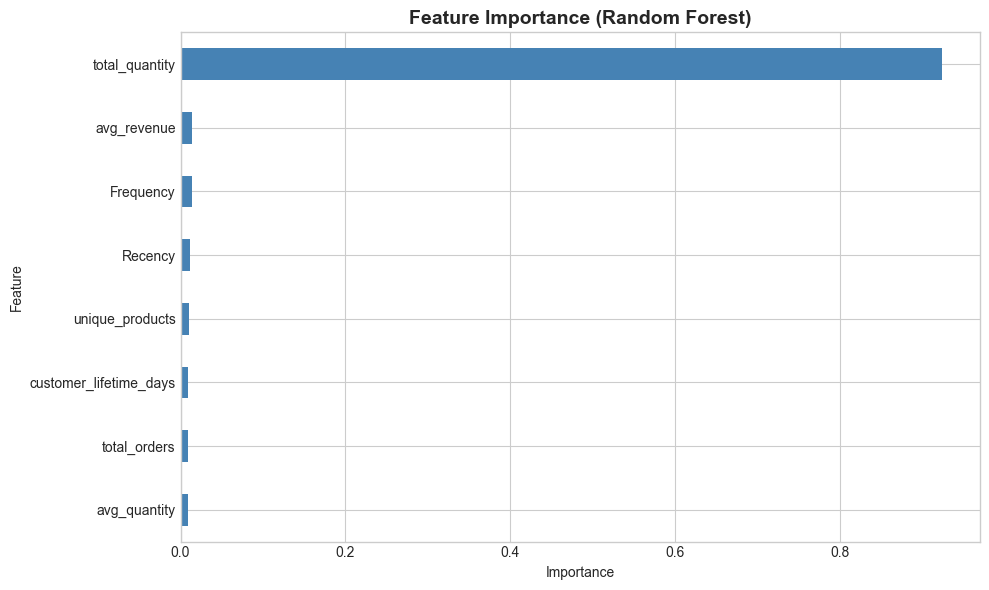

In [37]:
# Feature importance visualization
fig, ax = plt.subplots(figsize=(10, 6))

importance.plot(x='Feature', y='Importance', kind='barh', ax=ax, color='steelblue', legend=False)
ax.set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../data/processed/feature_importance.png', dpi=300)
plt.show()

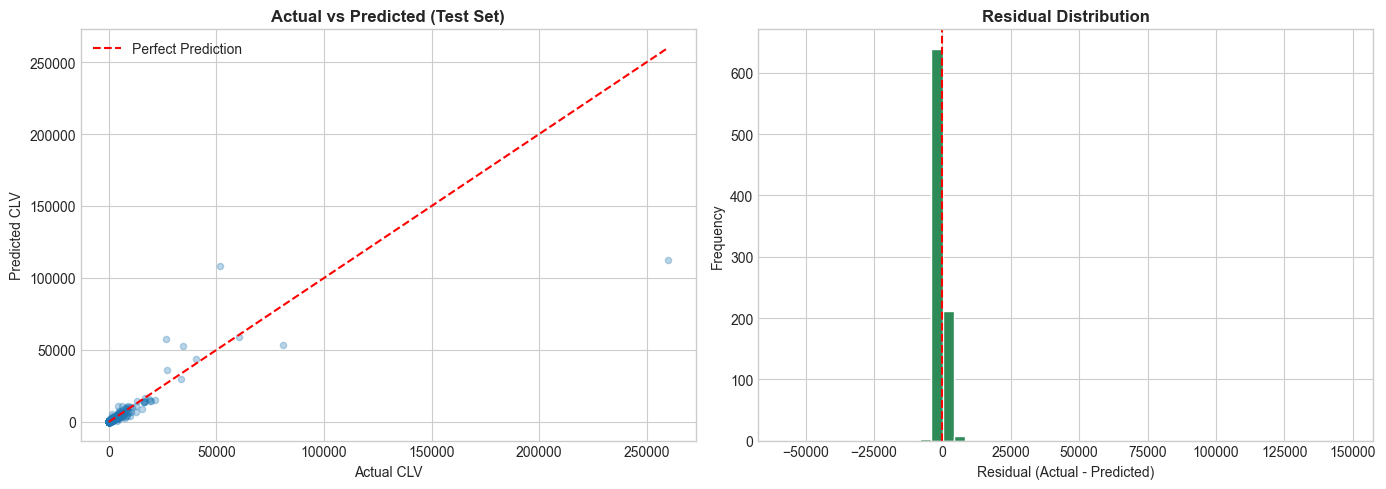

In [38]:
# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test set
axes[0].scatter(y_test, y_pred_test, alpha=0.3, s=20)
max_val = max(y_test.max(), y_pred_test.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual CLV')
axes[0].set_ylabel('Predicted CLV')
axes[0].set_title('Actual vs Predicted (Test Set)', fontweight='bold')
axes[0].legend()

# Residual distribution
residuals = y_test - y_pred_test
residuals.hist(bins=50, ax=axes[1], color='seagreen', edgecolor='white')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution', fontweight='bold')
axes[1].axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.savefig('../data/processed/actual_vs_predicted.png', dpi=300)
plt.show()

## 8. Generate CLV Predictions for All Customers

In [39]:
# Predict CLV for all customers
X_all = ml_features[feature_cols].fillna(0)
ml_features['CLV_ML'] = best_model.predict(X_all)

# Combine with probabilistic CLV
clv_results = ml_features[['CustomerID', 'Monetary', 'Segment', 'CLV_ML']].copy()

# Merge probabilistic CLV
prob_clv = rfm_repeat[['CustomerID', 'CLV_probabilistic', 'prob_alive', 'predicted_purchases_1y']]
clv_results = clv_results.merge(prob_clv, on='CustomerID', how='left')

# Fill missing probabilistic CLV with ML estimate
clv_results['CLV_probabilistic'] = clv_results['CLV_probabilistic'].fillna(clv_results['CLV_ML'] * 0.5)
clv_results['prob_alive'] = clv_results['prob_alive'].fillna(0.5)

# Create ensemble CLV (average of both models)
clv_results['CLV_ensemble'] = (clv_results['CLV_ML'] + clv_results['CLV_probabilistic']) / 2

print(f'CLV predictions generated for {len(clv_results):,} customers')
clv_results.head(10)

CLV predictions generated for 4,338 customers


,CustomerID,Monetary,Segment,CLV_ML,CLV_probabilistic,prob_alive,predicted_purchases_1y,CLV_ensemble
0,12346,77183.60,Hibernating,110161.923700,55080.961850,0.500000,NaN,82621.442775
1,12347,4310.00,Champions,4120.987564,150.903016,0.981107,5.934783,2135.945290
2,12348,1797.24,Loyal Customers,2876.270357,82.871770,0.654044,2.409335,1479.571064
3,12349,1757.55,New Customers,1313.306612,656.653306,0.500000,NaN,984.979959
4,12350,334.40,Hibernating,374.500023,187.250012,0.500000,NaN,280.875018
5,12352,2506.04,Loyal Customers,1842.811889,137.185455,0.607553,7.530978,989.998672
6,12353,89.00,Hibernating,117.994236,58.997118,0.500000,NaN,88.495677
7,12354,1079.40,Hibernating,980.451378,490.225689,0.500000,NaN,735.338533
8,12355,459.40,Hibernating,422.422451,211.211225,0.500000,NaN,316.816838
9,12356,2811.43,Potential Loyalists,2429.217301,85.993465,0.895450,2.074410,1257.605383


In [40]:
# CLV summary by segment
clv_by_segment = clv_results.groupby('Segment').agg({
    'CustomerID': 'count',
    'Monetary': 'sum',
    'CLV_ML': ['mean', 'sum'],
    'CLV_probabilistic': ['mean', 'sum'],
    'CLV_ensemble': ['mean', 'sum']
}).round(2)

clv_by_segment.columns = ['Customers', 'Historical_Revenue', 'Avg_CLV_ML', 'Total_CLV_ML',
                          'Avg_CLV_Prob', 'Total_CLV_Prob', 'Avg_CLV_Ensemble', 'Total_CLV_Ensemble']
clv_by_segment = clv_by_segment.sort_values('Total_CLV_Ensemble', ascending=False)

clv_by_segment

,Customers,Historical_Revenue,Avg_CLV_ML,Total_CLV_ML,Avg_CLV_Prob,Total_CLV_Prob,Avg_CLV_Ensemble,Total_CLV_Ensemble
Segment,,,,,,,,
Champions,957,5791640.74,5924.65,5669890.82,409.72,392102.90,3167.19,3030996.86
Loyal Customers,778,1327290.83,1691.19,1315747.96,77.07,59963.88,884.13,687855.92
Potential Loyalists,492,506813.63,1012.36,498083.57,216.12,106331.97,614.24,302207.77
Hibernating,664,315459.97,517.62,343697.08,233.92,155324.08,375.77,249510.58
Others,368,366413.24,945.25,347853.72,17.45,6421.75,481.35,177137.73
About to Sleep,401,202862.18,529.31,212253.68,198.73,79692.18,364.02,145972.93
Need Attention,373,256835.96,689.81,257298.28,88.97,33185.01,389.39,145241.65
Promising,164,68740.70,428.93,70344.00,214.46,35172.00,321.70,52758.00
New Customers,141,51151.64,387.02,54569.54,193.51,27284.77,290.26,40927.16


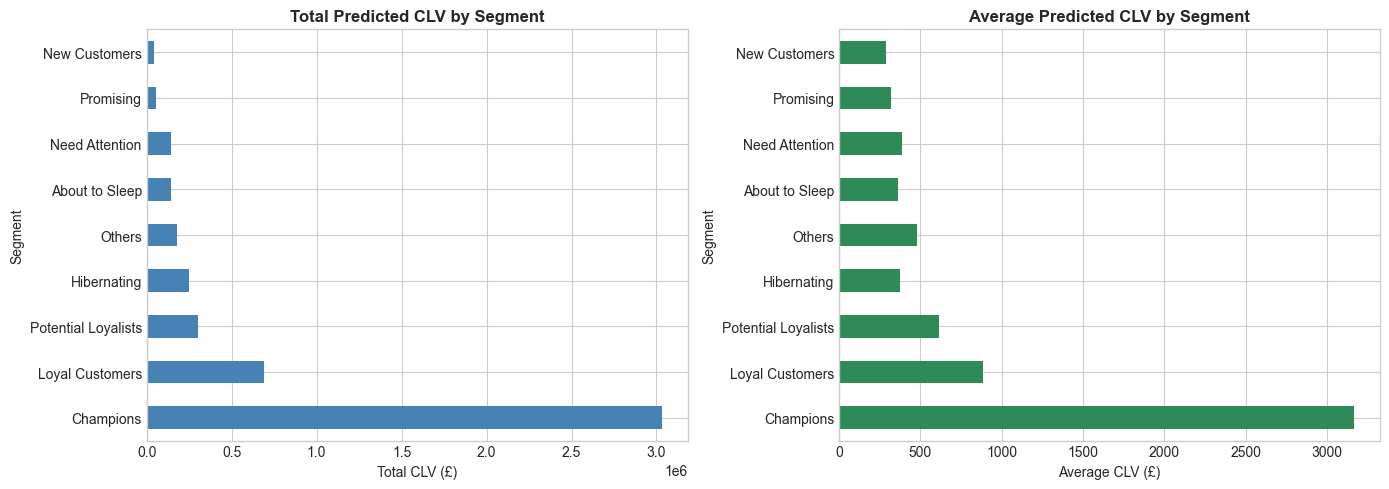

In [41]:
# CLV visualization by segment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total CLV by segment
clv_by_segment['Total_CLV_Ensemble'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Total Predicted CLV by Segment', fontweight='bold')
axes[0].set_xlabel('Total CLV (£)')

# Average CLV by segment
clv_by_segment['Avg_CLV_Ensemble'].plot(kind='barh', ax=axes[1], color='seagreen')
axes[1].set_title('Average Predicted CLV by Segment', fontweight='bold')
axes[1].set_xlabel('Average CLV (£)')

plt.tight_layout()
plt.savefig('../data/processed/clv_by_segment.png', dpi=300)
plt.show()

## 9. Key Insights

In [42]:
print('=' * 60)
print('CLV MODELING - KEY INSIGHTS')
print('=' * 60)

print('\n Model Performance:')
best = results_df.iloc[0]
print(f'   Best Model: {best["Model"]}')
print(f'   RMSE: £{best["RMSE"]:,.2f}')
print(f'   MAE: £{best["MAE"]:,.2f}')
print(f'   R²: {best["R2"]:.3f}')

print('\n CLV Summary:')
print(f'   Total Predicted CLV: £{clv_results["CLV_ensemble"].sum():,.2f}')
print(f'   Average CLV: £{clv_results["CLV_ensemble"].mean():,.2f}')
print(f'   Median CLV: £{clv_results["CLV_ensemble"].median():,.2f}')

print('\n Top Features for CLV:')
for i, row in importance.head(5).iterrows():
    print(f'   {row["Feature"]}: {row["Importance"]*100:.1f}%')

print('\n High-Value Segments:')
for seg in clv_by_segment.head(3).index:
    data = clv_by_segment.loc[seg]
    print(f'   {seg}: £{data["Total_CLV_Ensemble"]:,.0f} ({data["Customers"]:,} customers)')

print('\n' + '=' * 60)

CLV MODELING - KEY INSIGHTS

 Model Performance:
   Best Model: Random Forest
   RMSE: £5,642.19
   MAE: £668.97
   R²: 0.689

 CLV Summary:
   Total Predicted CLV: £4,832,608.60
   Average CLV: £1,114.02
   Median CLV: £398.14

 Top Features for CLV:
   total_quantity: 92.4%
   avg_revenue: 1.4%
   Frequency: 1.3%
   Recency: 1.1%
   unique_products: 1.0%

 High-Value Segments:
   Champions: £3,030,997 (957.0 customers)
   Loyal Customers: £687,856 (778.0 customers)
   Potential Loyalists: £302,208 (492.0 customers)



## 10. Save CLV Results

In [43]:
# Save CLV predictions
clv_results.to_csv('../data/features/clv_predictions.csv', index=False)
clv_by_segment.to_csv('../data/features/clv_by_segment.csv')
results_df.to_csv('../data/features/model_comparison.csv', index=False)

print('CLV results saved!')
print('  - clv_predictions.csv')
print('  - clv_by_segment.csv')
print('  - model_comparison.csv')

CLV results saved!
  - clv_predictions.csv
  - clv_by_segment.csv
  - model_comparison.csv


## Next Steps

Continue to **Notebook 06 - Advanced Segmentation** to:
- Apply K-Means clustering
- Perform Hierarchical clustering
- Create advanced customer segments